In [118]:
import pandas as pd
import requests
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score

import pickle
import joblib

On this notebook we will predict all days since our trainning data, which was until the fifth of May. The model will not be retrained between days, which is a possibility and should return better results.

# Extracting new data

In [97]:
def get_final_db(coins: list, symbols: list, days = int) -> pd.DataFrame:
    """
    Forms the df with the chosen coins
    
    Arguments:
    - coins: the name of the coins (lowercase) from the collected ids
    - symbols: coins symbols to use on the columns
    - days: number of days counting back from today, we want need
    Outputs:
    - final_df: Pandas DataFrame with historical data available and a data column
    """
    final_df = pd.DataFrame()
    
    for i in range(len(coins)):
        
        coin_url = 'https://api.coingecko.com/api/v3/coins/{}/market_chart?vs_currency=usd&days=max&interval=daily'.format(coins[i])
        
        # coin_url = 'https://api.coingecko.com/api/v3/coins/{}/market_chart?vs_currency=usd&days={}&interval=daily'.format(coins[i], days)
        # The URL when using number of days returns 2 values for the current day
        
        try:
          response = requests.get(coin_url)
        except (ConnectionError, Timeout, TooManyRedirects) as e:
          print(e)

        coin_df = pd.DataFrame()
        counter = 0
        
        for key in list(response.json().keys()):
            if counter == 0:
                coin_df = pd.DataFrame(response.json()[key])
                coin_df.columns = ['timestamp', key]
            else:
                df = pd.DataFrame(response.json()[key])
                df.columns = ['timestamp', key]
                coin_df = coin_df.merge(df, on = 'timestamp', how = 'left')
            counter =+ 1
        coin_df['date'] = coin_df.timestamp.apply(lambda x: datetime.fromtimestamp(x/1000)).dt.date

        print(symbols[i])
        print('Null Volumes: ', coin_df.total_volumes.isnull().sum())
        print('Null prices: ', coin_df.prices.isnull().sum())

        coin_df = coin_df.drop(columns = ['timestamp', 'market_caps'])
        coing_df = coin_df.sort_values(by=['date'])
        coin_df = coin_df[-days:]
        coin_df.columns = [symbols[i] + '_price', symbols[i] + '_volume', 'date']
        
        if i == 0:
            final_df = coin_df
        else:
            final_df = final_df.merge(coin_df, on='date', how='left')
            
    return final_df.set_index('date')

In [98]:
wanted_coins = ['bitcoin', 'ethereum', 'binancecoin', 'vechain','bittorrent-2', 'holotoken']
respective_symbols = ['btc', 'eth', 'bnb', 'vet', 'btt', 'hot']

In [99]:
final_df = get_final_db(wanted_coins, respective_symbols, 20)

btc
Null Volumes:  0
Null prices:  0
eth
Null Volumes:  0
Null prices:  0
bnb
Null Volumes:  0
Null prices:  0
vet
Null Volumes:  0
Null prices:  0
btt
Null Volumes:  0
Null prices:  0
hot
Null Volumes:  0
Null prices:  0


In [110]:
final_df.head(20)

,btc_price,btc_volume,eth_price,eth_volume,bnb_price,bnb_volume,vet_price,vet_volume,btt_price,btt_volume,hot_price,hot_volume
date,,,,,,,,,,,,
2021-04-25,50133.107396,4.929626e+10,2212.843798,3.564059e+10,499.323274,4.991523e+09,0.182289,3.159223e+09,0.006971,5.260638e+09,0.012187,6.980889e+08
2021-04-26,48981.441393,4.623343e+10,2307.355321,3.674440e+10,506.047307,4.198997e+09,0.171895,2.491716e+09,0.006659,2.019773e+09,0.011633,3.300582e+08
2021-04-27,53978.805547,6.022693e+10,2532.386803,4.279180e+10,533.583525,5.295873e+09,0.191114,3.002716e+09,0.007174,2.108571e+09,0.013851,5.360496e+08
2021-04-28,54991.814843,4.846856e+10,2647.158190,3.761160e+10,568.966920,4.398525e+09,0.210912,3.559226e+09,0.007554,2.571500e+09,0.016585,8.835258e+08
2021-04-29,54810.613851,4.807293e+10,2748.784585,4.287874e+10,562.577780,4.808744e+09,0.200108,2.838729e+09,0.007221,1.885252e+09,0.015807,6.067193e+08
2021-04-30,53596.704023,4.695804e+10,2757.497552,3.853687e+10,599.878912,8.239014e+09,0.192807,2.379181e+09,0.007038,1.069812e+09,0.015487,3.354028e+08
2021-05-01,57828.511814,5.387905e+10,2776.703712,3.547788e+10,624.576535,7.224920e+09,0.202759,2.091602e+09,0.007387,1.342079e+09,0.016122,3.467308e+08
2021-05-02,57812.969160,4.396707e+10,2944.916947,3.672165e+10,619.030889,5.343009e+09,0.206364,1.764292e+09,0.007396,1.351199e+09,0.016211,4.126239e+08
2021-05-03,56600.745287,3.907266e+10,2953.297348,3.572743e+10,622.587767,4.766464e+09,0.218802,3.061196e+09,0.007200,1.020262e+09,0.015586,3.006364e+08


# Feature Engineering

In [104]:
def create_lagged_features(df: pd.DataFrame) -> pd.DataFrame:
    
    """
    Creates df for our model to predict
    
    Arguments:
    - df: DataFrame with coin values and volumes
    Outputs:
    - X_lagged: DataFrame with the new lagged values
    """
    
    data = df.copy()
    
    X = data.drop(columns = ['hot_price', 'hot_volume'])
    
    lag_1 = X.shift(1)
    lag_1.columns = ['lagged_1_' + column for column in X.columns]

    lag_2 = X.shift(2)
    lag_2.columns = ['lagged_2_' + column for column in X.columns]

    lag_3 = X.shift(3)
    lag_3.columns = ['lagged_3_' + column for column in X.columns]

    lag_4 = X.shift(4)
    lag_4.columns = ['lagged_4_' + column for column in X.columns]

    lag_5 = X.shift(4)
    lag_5.columns = ['lagged_5_' + column for column in X.columns]
    
    X_lagged = (
        lag_1.iloc[5:]
        .join(lag_2.iloc[5:])
        .join(lag_3.iloc[5:])
        .join(lag_4.iloc[5:])
        .join(lag_5.iloc[5:])
    )
    
    return X_lagged

In [106]:
X = create_lagged_features(final_df[6:])

In [111]:
X.head()

,lagged_1_btc_price,lagged_1_btc_volume,lagged_1_eth_price,lagged_1_eth_volume,lagged_1_bnb_price,lagged_1_bnb_volume,lagged_1_vet_price,lagged_1_vet_volume,lagged_1_btt_price,lagged_1_btt_volume,...,lagged_5_btc_price,lagged_5_btc_volume,lagged_5_eth_price,lagged_5_eth_volume,lagged_5_bnb_price,lagged_5_bnb_volume,lagged_5_vet_price,lagged_5_vet_volume,lagged_5_btt_price,lagged_5_btt_volume
date,,,,,,,,,,,,,,,,,,,,,
2021-05-06,53464.370220,7.129676e+10,3245.663149,7.843724e+10,608.632898,7.324619e+09,0.191784,2.656120e+09,0.006595,1.707581e+09,...,57812.969160,4.396707e+10,2944.916947,3.672165e+10,619.030889,5.343009e+09,0.206364,1.764292e+09,0.007396,1.351199e+09
2021-05-07,57432.100227,7.215837e+10,3524.562728,6.355234e+10,651.830238,5.349088e+09,0.209209,2.540024e+09,0.007396,3.534128e+09,...,56600.745287,3.907266e+10,2953.297348,3.572743e+10,622.587767,4.766464e+09,0.218802,3.061196e+09,0.007200,1.020262e+09
2021-05-08,56507.759440,8.751080e+10,3495.075869,5.043017e+10,635.543299,5.775171e+09,0.218906,2.914858e+09,0.008127,5.168930e+09,...,57200.300299,5.413247e+10,3439.855070,6.419265e+10,675.098974,6.575775e+09,0.212997,2.162001e+09,0.007129,1.225629e+09
2021-05-09,57361.569043,6.815481e+10,3493.534500,4.498077e+10,625.094396,4.590422e+09,0.233651,4.856459e+09,0.007930,5.531345e+09,...,53464.370220,7.129676e+10,3245.663149,7.843724e+10,608.632898,7.324619e+09,0.191784,2.656120e+09,0.006595,1.707581e+09
2021-05-10,58771.881690,6.681217e+10,3912.742917,6.017492e+10,645.058576,4.816849e+09,0.226362,2.093137e+09,0.007677,2.031064e+09,...,57432.100227,7.215837e+10,3524.562728,6.355234e+10,651.830238,5.349088e+09,0.209209,2.540024e+09,0.007396,3.534128e+09


# Getting our model

In [125]:
with open('columns.json') as fh:
    columns = json.load(fh)

model = joblib.load('RFR.pickle')

with open('dtypes.pickle', 'rb') as fh:
    dtypes = pickle.load(fh)

In [126]:
predictions = model.predict(X)

In [127]:
print('Mean Squared Error: ', mean_squared_error(final_df[['hot_price']][11:], predictions))
print('r2_score: ', r2_score(final_df[['hot_price']][11:], predictions))

Mean Squared Error:  6.963577113781427e-06
r2_score:  -2.511377632996977


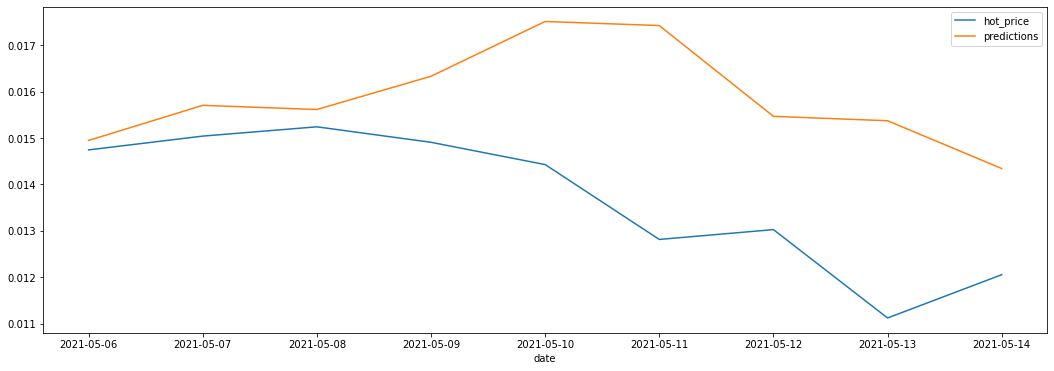

In [128]:
to_plot = final_df[['hot_price']][11:]
to_plot['predictions'] = predictions

to_plot.plot(figsize = [18, 6])
plt.show()